# Exploratory Data Analysis of New York Times Article Topics, Titles, and Summaries

In [1]:
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'

from collections import Counter
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import collocations
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/dariaageikina/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/dariaageikina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

## The data comes from the Comparative Agendas Project
### They categorized each article's topic manually and added the summaries. The dictionary to the data is [here](https://minio.la.utexas.edu/compagendas/codebookfiles/NYT_Front_Page_Policy_Agendas_Codebook_Updated_with_new_CAP_Codes.pdf).

In [2]:
url = 'https://minio.la.utexas.edu/compagendas/adhocfiles/Boydstun_NYT_FrontPage_Dataset_1996-2006_0_PAP2014_recoding_wmanual_full.csv'
cap_nyt = pd.read_csv(url, encoding="latin1")
cap_nyt.head()

,article_id,date,title,summary,topic_2digit,topic_4digit,topic_6digit,CAPtopic_2digit,CAPtopic_4digit,CAPtopic_6digit,...,waronterror,katrina,israelpalestine,immigration,presidentialelections,clintonimpeachment,enron,darfur,raceethnicity,schiavo
0,7662,8/10/98,Talks Are Pressed to End Strike By Phone Worke...,Talks held to end phone workers strike,5,504,50400,17,1706,170600,...,0,0,0,0,0,0,0,0,0,0
1,28483,12/21/05,Pensions Were Last Sticking Point,NYC transit strike,5,504,50400,10,1000,100000,...,0,0,0,0,0,0,0,0,0,0
2,2581,11/17/96,"Once Again, the Hoffa Name Rouses the Teamster...",teamsters union,5,504,50400,10,1006,100600,...,0,0,0,0,0,0,0,0,0,0
3,28531,12/28/05,TRANSIT WORKERS IN DEAL TO SHARE HEALTH PLAN COST,NYC transit workers' strike settlement,5,504,50400,10,1000,100000,...,0,0,0,0,0,0,0,0,0,0
4,19942,10/9/02,PRESIDENT INVOKES TAFT-HARTLEY ACT TO OPEN 29 ...,Taft-Hartley Act invoked to reopen closed ports,5,504,50400,10,1007,100700,...,0,0,0,0,0,0,0,0,0,0


In [3]:
print(cap_nyt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31034 entries, 0 to 31033
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   article_id              31034 non-null  int64  
 1   date                    31034 non-null  object 
 2   title                   31031 non-null  object 
 3   summary                 30976 non-null  object 
 4   topic_2digit            31034 non-null  int64  
 5   topic_4digit            31034 non-null  int64  
 6   topic_6digit            31034 non-null  int64  
 7   CAPtopic_2digit         31034 non-null  int64  
 8   CAPtopic_4digit         31034 non-null  int64  
 9   CAPtopic_6digit         31034 non-null  int64  
 10  manually_recode         31034 non-null  int64  
 11  recoded                 0 non-null      float64
 12  keyword_animal          77 non-null     float64
 13  keyword_domestic        77 non-null     float64
 14  keyword_welfare         77 non-null   

## Analyze the topics

**The main variable of interest is topic_2digit, but we only have its numeric representation. Let's assign descriptive labels to the data, retrieved manually from the data dictionary:**

In [4]:
topic_dict = {
    1: "Macroeconomics",
    2: "Civil Rights, Minority Issues, and Civil Liberties",
    3: "Health",
    4: "Agriculture",
    5: "Labor and Employment",
    6: "Education",
    7: "Environment",
    8: "Energy",
    9: "Immigration",
    10: "Transportation",
    12: "Law, Crime, and Family Issues",
    13: "Social Welfare",
    14: "Community Development and Housing Issues",
    15: "Banking, Finance, and Domestic Commerce",
    16: "Defense",
    17: "Space, Science, Technology and Communications",
    18: "Foreign Trade",
    19: "International Affairs and Foreign Aid",
    20: "Government Operations",
    21: "Public Lands and Water Management",
    23: "Arts and Entertainment",
    24: "State and Local Government Administration",
    26: "Weather and Natural Disasters",
    27: "Fires",
    29: "Sports and Recreation",
    30: "Death Notices",
    31: "Churches and Religion",
    99: "Other, Miscellaneous, and Human Interest"
}

In [5]:
cap_nyt['topic_label'] = cap_nyt['topic_2digit'].map(topic_dict)
#leave only variables of interest
cap_nyt = cap_nyt[['article_id','date','title','summary','topic_2digit','topic_label','topic_4digit','topic_6digit']]
cap_nyt.head()

,article_id,date,title,summary,topic_2digit,topic_label,topic_4digit,topic_6digit
0,7662,8/10/98,Talks Are Pressed to End Strike By Phone Worke...,Talks held to end phone workers strike,5,Labor and Employment,504,50400
1,28483,12/21/05,Pensions Were Last Sticking Point,NYC transit strike,5,Labor and Employment,504,50400
2,2581,11/17/96,"Once Again, the Hoffa Name Rouses the Teamster...",teamsters union,5,Labor and Employment,504,50400
3,28531,12/28/05,TRANSIT WORKERS IN DEAL TO SHARE HEALTH PLAN COST,NYC transit workers' strike settlement,5,Labor and Employment,504,50400
4,19942,10/9/02,PRESIDENT INVOKES TAFT-HARTLEY ACT TO OPEN 29 ...,Taft-Hartley Act invoked to reopen closed ports,5,Labor and Employment,504,50400


**Check if there are news with no topic labels:**

In [6]:
cap_nyt[cap_nyt['topic_label'].isna()].shape[0]

769

In [7]:
cap_nyt[cap_nyt['topic_label'].isna()]["topic_2digit"].unique()

array([28])

There are 769 rows where the topic is 28, but no corresponding label exists in the data dictionary. The [dictionary](https://minio.la.utexas.edu/compagendas/codebookfiles/NYT_Front_Page_Policy_Agendas_Codebook_Updated_with_new_CAP_Codes.pdf), however, states that code 28 was changed to 23 (page 27).

**Let’s examine the rows where the topic is coded as 23.**

In [8]:
cap_nyt[cap_nyt['topic_2digit']==23].shape[0]

0

Apparently, the topics haven't been fully recoded. Let's fix this:

In [9]:
topic_dict[28] = topic_dict.pop(23)

cap_nyt['topic_label'] = cap_nyt['topic_2digit'].map(topic_dict)
cap_nyt[cap_nyt['topic_label'].isna()].shape[0]

0

We're good!

**Check the distribution of the topics:**

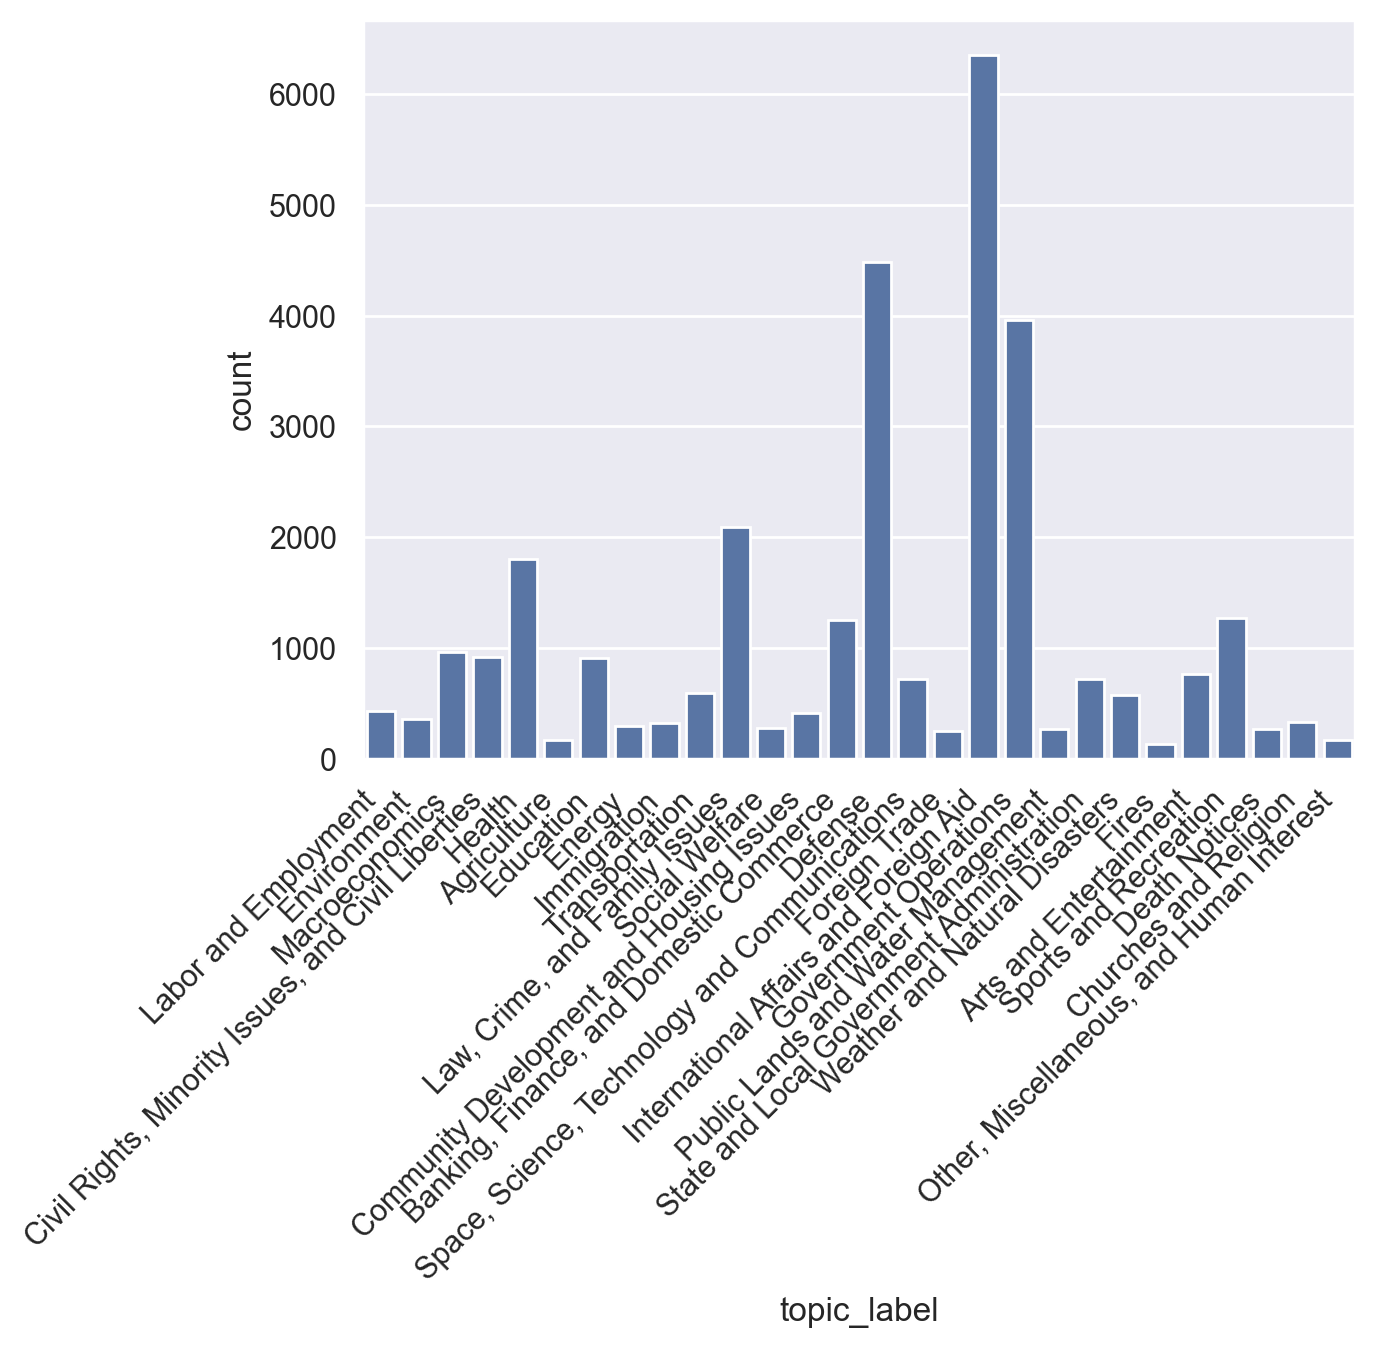

In [10]:
sns.countplot(x="topic_label", data=cap_nyt)

plt.xticks(rotation=45, ha='right')
plt.show()

In [11]:
cap_nyt["topic_label"].value_counts()

topic_label
International Affairs and Foreign Aid                 6354
Defense                                               4479
Government Operations                                 3958
Law, Crime, and Family Issues                         2088
Health                                                1799
Sports and Recreation                                 1273
Banking, Finance, and Domestic Commerce               1249
Macroeconomics                                         964
Civil Rights, Minority Issues, and Civil Liberties     914
Education                                              912
Arts and Entertainment                                 769
Space, Science, Technology and Communications          719
State and Local Government Administration              715
Transportation                                         594
Weather and Natural Disasters                          573
Labor and Employment                                   429
Community Development and Housing Issues    

**Track topics throughout years**:

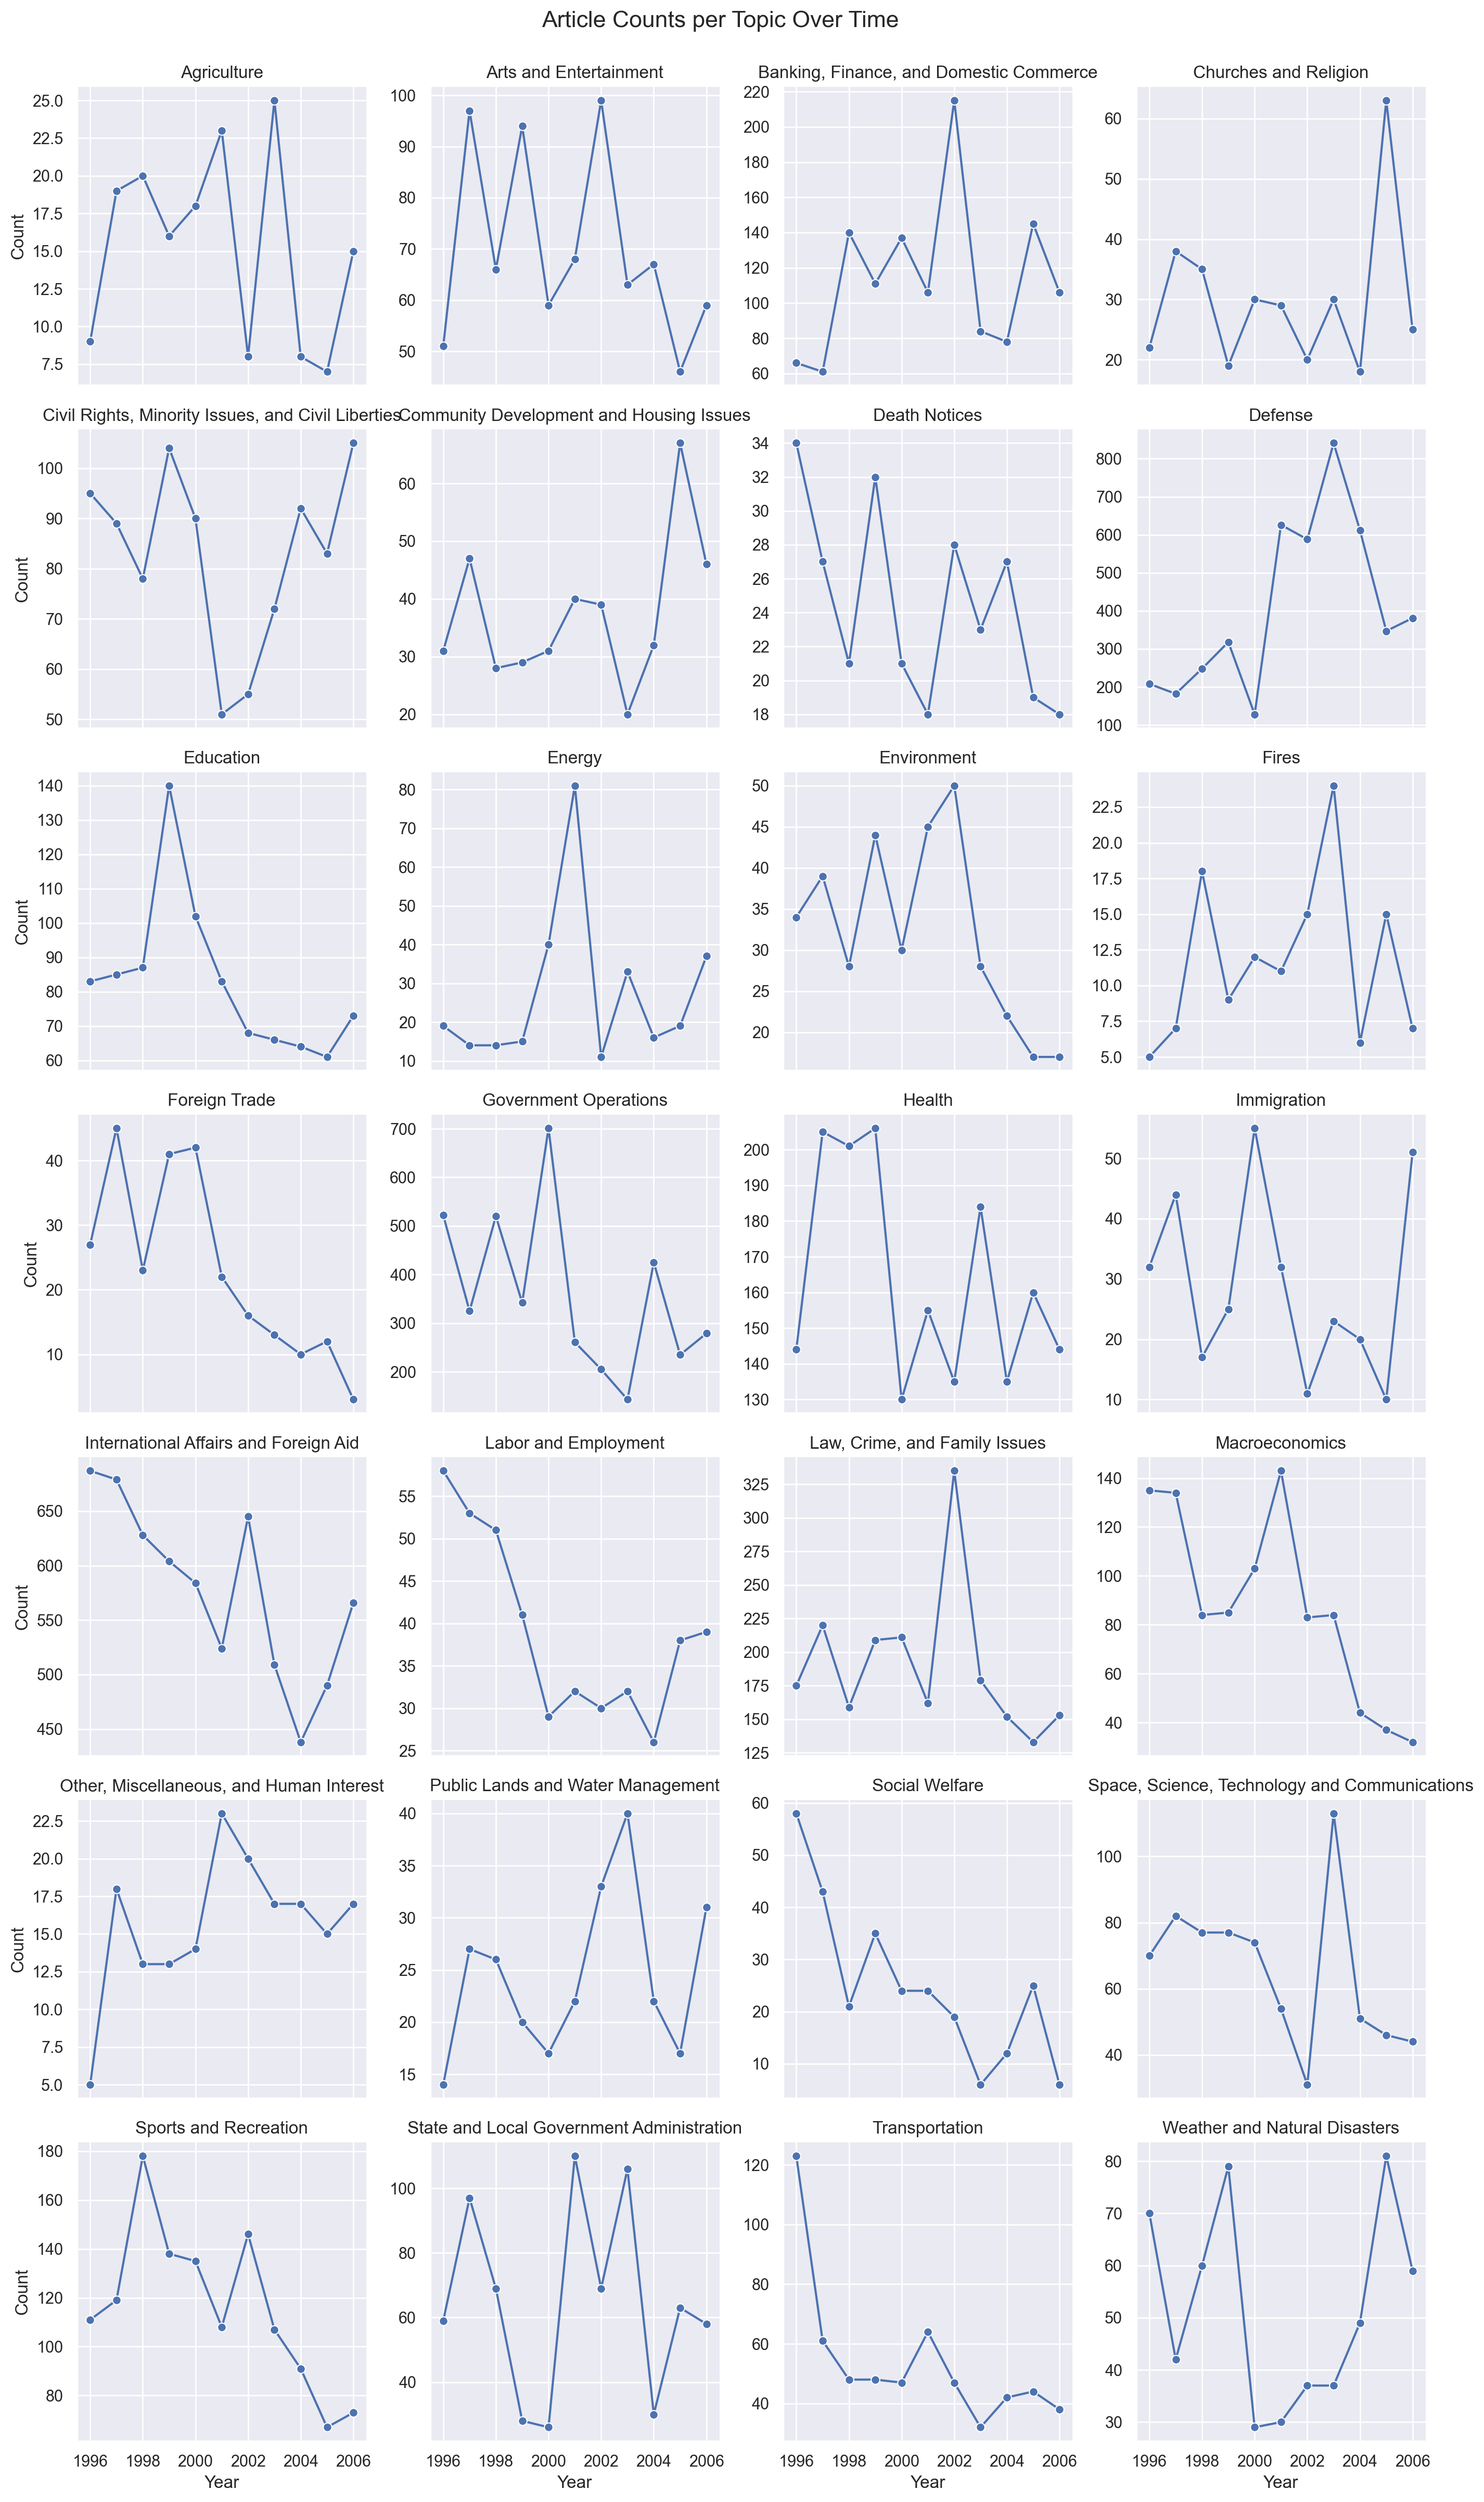

In [12]:
#clean the date variable
cap_nyt['date'] = pd.to_datetime(cap_nyt['date'], format="%m/%d/%y")
cap_nyt['year'] = cap_nyt['date'].dt.year

counts = cap_nyt.groupby(['year', 'topic_label']).size().reset_index(name='count')

g = sns.FacetGrid(counts, col='topic_label', col_wrap=4, sharey=False, height=3.5)
g.map_dataframe(sns.lineplot, x='year', y='count', marker='o')

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Year", "Count")
g.tight_layout()
plt.subplots_adjust(top=0.95)
g.fig.suptitle("Article Counts per Topic Over Time", fontsize=16)

plt.show()

There is considerable volatility in the coverage of topics over the years. Only a few topics exhibit relatively steady trends over time. We observe an increasing amount of coverage related to defense, and a somewhat decreasing focus on education, social welfare, and sports and recreation.

## Analyze tokens in titles and summaries

**Clean the titles and summaries:**

In [13]:
def clean_text(text):
    if isinstance(text, str):
        #Remove numbers
        text = re.sub(r"[0-9]", "", text)
        #Separate words with hyphens (e.g. "self-taught" will become "self taught")
        text = re.sub(r"-", " ", text)
        text = re.sub(r"[-—]", " ", text)
        # Remove the rest of punctuation and underscores
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r"_", "", text)        
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text)
                
    return text

wordnet = nltk.corpus.wordnet

def convert_tag(tag):
    """Convert a TreeBank tag to a WordNet tag."""
    if tag.startswith('J'):
        tag = wordnet.ADJ
    elif tag.startswith('V'):
        tag = wordnet.VERB
    elif tag.startswith('N'):
        tag = wordnet.NOUN
    elif tag.startswith('R'):
        tag = wordnet.ADV
    else:
        tag = ''

    return tag

lemmatizer = WordNetLemmatizer()

def lemmatize_word(word, tag):
    if tag:
        return lemmatizer.lemmatize(word, pos = tag)

    return word
    
def lemmatize_text(text):
    if isinstance(text, str):
        #tokenize
        tokenized = nltk.word_tokenize(text.lower())
        tagged = nltk.pos_tag(tokenized)
        tagged = [(word, convert_tag(tag)) for (word, tag) in tagged]
        lemmatized = [lemmatize_word(word, tag) for (word, tag) in tagged]
        joined = " ".join(lemmatized)
        return joined
    else:
        return text

cap_nyt['title_lemmatized'] = cap_nyt['title'].apply(lemmatize_text)
cap_nyt['title_clean'] = cap_nyt['title_lemmatized'].apply(clean_text)
cap_nyt['summary_lemmatized'] = cap_nyt['summary'].apply(lemmatize_text)
cap_nyt['summary_clean'] = cap_nyt['summary_lemmatized'].apply(clean_text)

#remove stopwords
stop = stopwords.words('english') + ['overview','review','say','tell','mention','report','according','news']
cap_nyt['title_clean'] = cap_nyt['title_clean'].apply(
    lambda x: ' '.join([word for word in str(x).split() if word not in stop]) if isinstance(x, str) else x
)
cap_nyt['summary_clean'] = cap_nyt['summary_clean'].apply(
    lambda x: ' '.join([word for word in str(x).split() if word not in stop]) if isinstance(x, str) else x
)

cap_nyt.head()

,article_id,date,title,summary,topic_2digit,topic_label,topic_4digit,topic_6digit,year,title_lemmatized,title_clean,summary_lemmatized,summary_clean
0,7662,1998-08-10,Talks Are Pressed to End Strike By Phone Worke...,Talks held to end phone workers strike,5,Labor and Employment,504,50400,1998,talk be press to end strike by phone worker on...,talk press end strike phone worker east coast,talk hold to end phone worker strike,talk hold end phone worker strike
1,28483,2005-12-21,Pensions Were Last Sticking Point,NYC transit strike,5,Labor and Employment,504,50400,2005,pension be last sticking point,pension last sticking point,nyc transit strike,nyc transit strike
2,2581,1996-11-17,"Once Again, the Hoffa Name Rouses the Teamster...",teamsters union,5,Labor and Employment,504,50400,1996,"once again , the hoffa name rouse the teamster...",hoffa name rouse teamster union,teamster union,teamster union
3,28531,2005-12-28,TRANSIT WORKERS IN DEAL TO SHARE HEALTH PLAN COST,NYC transit workers' strike settlement,5,Labor and Employment,504,50400,2005,transit worker in deal to share health plan cost,transit worker deal share health plan cost,nyc transit worker ' strike settlement,nyc transit worker strike settlement
4,19942,2002-10-09,PRESIDENT INVOKES TAFT-HARTLEY ACT TO OPEN 29 ...,Taft-Hartley Act invoked to reopen closed ports,5,Labor and Employment,504,50400,2002,president invokes taft-hartley act to open 29 ...,president invokes taft hartley act open port,taft-hartley act invoke to reopen closed port,taft hartley act invoke reopen closed port


**Count unique words in titles and summaries (both raw and clean) and check most common ones:**

In [14]:
# Function to count unique words in a column
def count_unique_words(column):
    all_text = ' '.join(str(x) for x in column if pd.notnull(x))
    words = all_text.split()
    word_counts = Counter(words)
    return len(word_counts), word_counts

# Count words in each column
for col in ['title', 'title_clean', 'summary', 'summary_clean']:
    num_unique, most_freq_words = count_unique_words(cap_nyt[col])
    print(f"Column '{col}' - Number of unique words: {num_unique}")
    for entry in most_freq_words.most_common(25):
        print(entry) 

Column 'title' - Number of unique words: 33834
('THE', 4484)
('in', 3937)
('to', 3792)
('A', 3683)
('of', 3502)
('a', 3212)
('the', 2977)
('In', 2610)
('IN', 2268)
('U.S.', 2252)
('and', 1995)
('for', 1974)
('Is', 1964)
('TO', 1781)
('on', 1656)
('New', 1635)
('To', 1456)
('For', 1382)
('The', 1190)
('OF', 1183)
('On', 1138)
('ON', 986)
('With', 903)
('at', 883)
('Of', 874)
Column 'title_clean' - Number of unique words: 13393
('us', 2430)
('new', 2076)
('bush', 1197)
('iraq', 1163)
('plan', 950)
('war', 833)
('nation', 810)
('clinton', 725)
('president', 707)
('campaign', 663)
('city', 612)
('vote', 573)
('challenge', 572)
('york', 554)
('find', 552)
('court', 551)
('case', 545)
('seek', 533)
('attack', 517)
('special', 503)
('kill', 503)
('back', 494)
('see', 489)
('china', 487)
('house', 485)
Column 'summary' - Number of unique words: 24486
('in', 7389)
('of', 6532)
('to', 6299)
('the', 3017)
('for', 2872)
('and', 2536)
('on', 2240)
('a', 1538)
('US', 1140)
('with', 1039)
('Iraq', 98

As expected, cleaned columns have less unique words. However, summaries have less words than titles, contrary to what one may expect.

Most common words in raw titles and summaries are stopwords. Some words like "new" and "york" should be combined together.

**Let's deal with N-grams**:

In [15]:
def get_bigrams(column_name):
    all_clean_title_words = ' '.join(str(x) for x in cap_nyt[column_name] if pd.notnull(x))
    cleaned_title_words = all_clean_title_words.split()
    finder = collocations.BigramCollocationFinder.from_words(cleaned_title_words)
    
    bigrams = finder.ngram_fd
    bigrams = [(word, pair, count) for (word, pair), count in bigrams.items()]
    bigrams = pd.DataFrame(bigrams, columns = ('word', 'pair', 'count'))
    bigrams.sort_values('count', ascending = False, inplace = True)

    return bigrams

bigrams=get_bigrams("title_clean")
bigrams.head(25)

,word,pair,count
387,new,york,552
2498,nation,challenge,475
6319,threat,response,231
53825,crisis,balkan,225
4351,white,house,190
22444,nation,war,179
109497,testing,president,145
1581,new,jersey,131
53763,struggle,iraq,101
6823,supreme,court,100


In [16]:
bigrams=get_bigrams("summary_clean")
bigrams.head(25)

,word,pair,count
222,new,york,611
4536,supreme,court,311
1394,presidential,election,298
87883,campaign,finance,142
915,white,house,141
3144,tax,cut,133
765,stock,market,132
223,york,city,127
43151,iraq,war,120
231,new,jersey,115


In [17]:
#fix bigrams and other common words that haven't been lemmatized properly or that are now irrelevant
def clean_phrases(text):
    if isinstance(text, str):
        text = text.lower()
        text = text.replace('new york city', 'nyc')
        text = text.replace('new york', 'ny')
        text = text.replace('white house', 'whitehouse')
        text = text.replace('new jersey', 'newjersey')
        text = text.replace('new orleans', 'neworleans')
        text = text.replace('west bank', 'westbank')
        text = text.replace('ca nt', '')
        text = text.replace('wo nt', '')
        text = text.replace('stock market', 'stockmarket')
        text = text.replace('job market', 'jobmarket')
        text = text.replace('north korea', 'northkorea')
        text = text.replace('south korea', 'southkorea')
        text = text.replace('al qaeda', 'alqaeda')
        text = text.replace('presidential', 'president')
        text = text.replace('testing', 'test')
        text = text.replace('special today','')
        text = text.replace('new','')
        text = clean_text(text) #in case extra spaces appeared
    return text

cap_nyt['title_clean'] = cap_nyt['title_clean'].apply(clean_phrases)
cap_nyt['summary_clean'] = cap_nyt['summary_clean'].apply(clean_phrases)

In [18]:
bigrams=get_bigrams("title_clean")
bigrams.head(25)

,word,pair,count
2476,nation,challenge,475
6275,threat,response,231
53658,crisis,balkan,225
22294,nation,war,179
52438,test,president,147
53596,struggle,iraq,101
6773,supreme,court,100
2044,tax,cut,90
43885,bin,laden,75
9504,health,care,71


In [19]:
bigrams=get_bigrams("summary_clean")
bigrams.head(25)

,word,pair,count
4521,supreme,court,311
1375,president,election,298
87617,campaign,finance,142
3134,tax,cut,133
42964,iraq,war,120
4729,court,rule,114
53742,iraq,insurgency,109
8960,health,care,108
840,bush,administration,102
30981,abuse,scandal,100


We seemingly resolved the issue with the most common bigrams!

In [20]:
#count most frequent words again
for col in ['title_clean','summary_clean']:
    num_unique, most_freq_words = count_unique_words(cap_nyt[col])
    print(f"Column '{col}' - Number of unique words: {num_unique}")
    for entry in most_freq_words.most_common(25):
        print(entry) 

Column 'title_clean' - Number of unique words: 13390
('us', 2430)
('bush', 1197)
('iraq', 1163)
('plan', 950)
('war', 833)
('nation', 810)
('president', 740)
('clinton', 725)
('campaign', 663)
('vote', 573)
('challenge', 572)
('city', 553)
('find', 552)
('court', 551)
('case', 545)
('seek', 533)
('attack', 517)
('kill', 503)
('back', 494)
('ny', 494)
('test', 491)
('see', 489)
('china', 487)
('school', 476)
('big', 473)
Column 'summary_clean' - Number of unique words: 12002
('us', 1864)
('iraq', 1333)
('bush', 1305)
('clinton', 1086)
('election', 1049)
('nyc', 983)
('ny', 919)
('president', 905)
('campaign', 801)
('plan', 686)
('attack', 658)
('american', 640)
('school', 615)
('war', 588)
('scandal', 576)
('court', 535)
('state', 526)
('iraqi', 514)
('senate', 457)
('china', 447)
('drug', 443)
('kill', 424)
('trial', 418)
('government', 414)
('republican', 401)


**Add the counts of tokens and unique words in both titles and summaries, and check how titles and summaries differ:**

In [21]:
cap_nyt['title_token_count'] = cap_nyt['title_lemmatized'].str.split().str.len().round().astype('Int64')
cap_nyt['summary_token_count'] = cap_nyt['summary_lemmatized'].str.split().str.len().round().astype('Int64')
cap_nyt['title_unique_words'] = cap_nyt['title_clean'].apply(lambda x: len(set(x.split())) if pd.notnull(x) else 0)
cap_nyt['summary_unique_words'] = cap_nyt['summary_clean'].apply(lambda x: len(set(x.split())) if pd.notnull(x) else 0)

**Visualize the differences:**

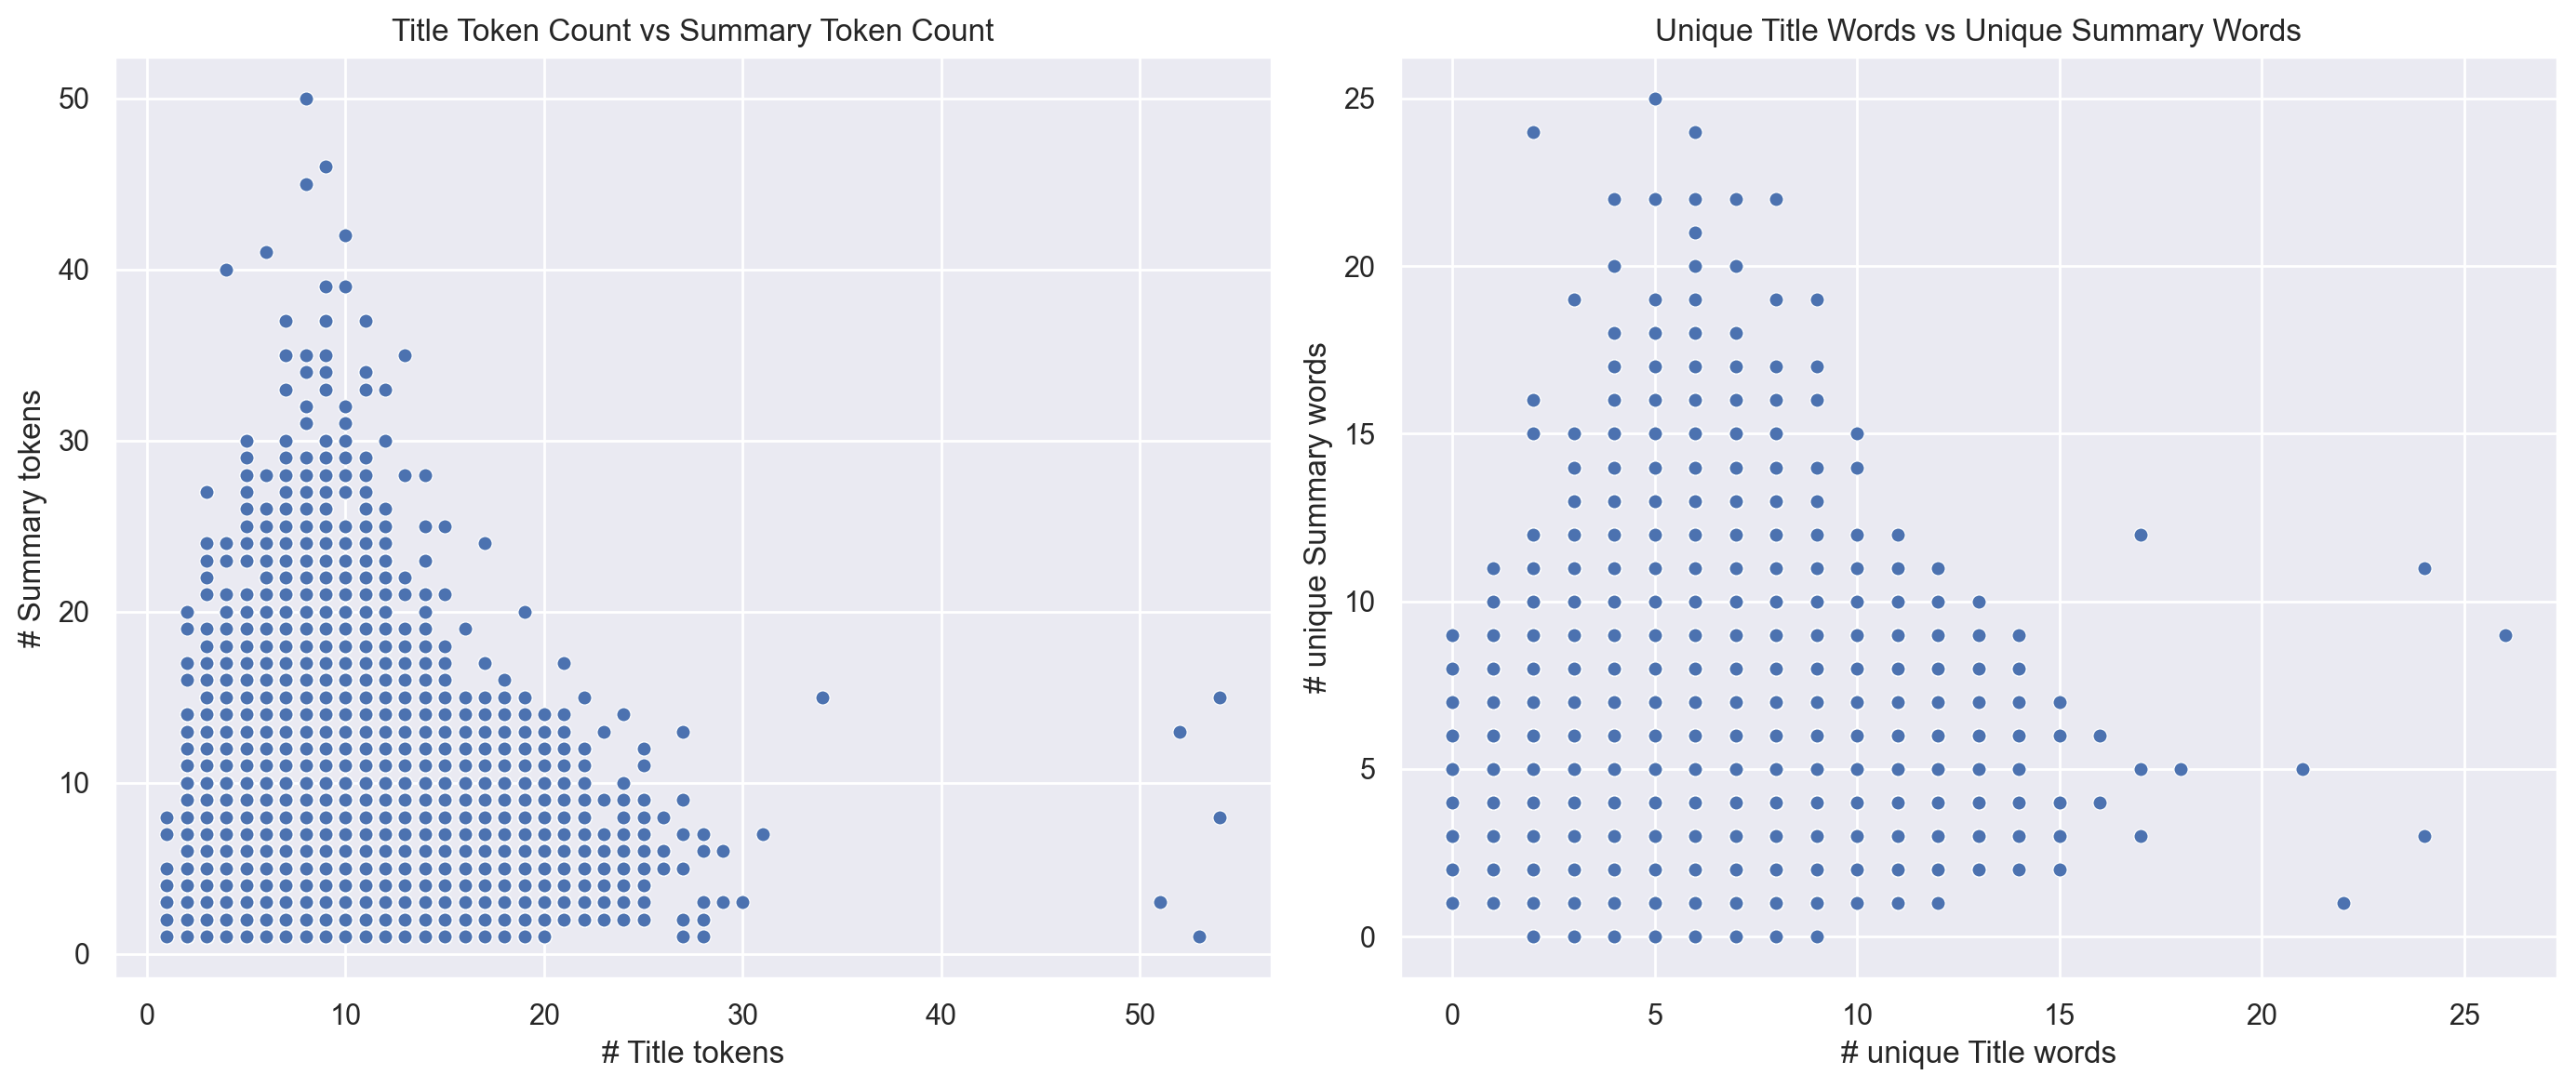

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Scatterplot 1
sns.scatterplot(data=cap_nyt, x='title_token_count', y='summary_token_count', s=30, ax=axes[0])
axes[0].set_title("Title Token Count vs Summary Token Count")
axes[0].set_xlabel("# Title tokens")
axes[0].set_ylabel("# Summary tokens")

# Scatterplot 2
sns.scatterplot(data=cap_nyt, x='title_unique_words', y='summary_unique_words', s=30, ax=axes[1])
axes[1].set_title("Unique Title Words vs Unique Summary Words")
axes[1].set_xlabel("# unique Title words")
axes[1].set_ylabel("# unique Summary words")

plt.tight_layout()
plt.show()

**Check the correlation:**

In [23]:
print("Correlation between title and summary tokens:", cap_nyt['title_token_count'].corr(cap_nyt['summary_token_count']))
print("Correlation between title and summary unique words:", cap_nyt['title_unique_words'].corr(cap_nyt['summary_unique_words']))

Correlation between title and summary tokens: 0.013513016652976488
Correlation between title and summary unique words: 0.1060353828215583


Interestingly, the correlations between counts for titles and summaries are quite low. Also, articles with very high token/word count for titles have lower token/word count for summaries and vice versa.

**Check token frequency distribution:**

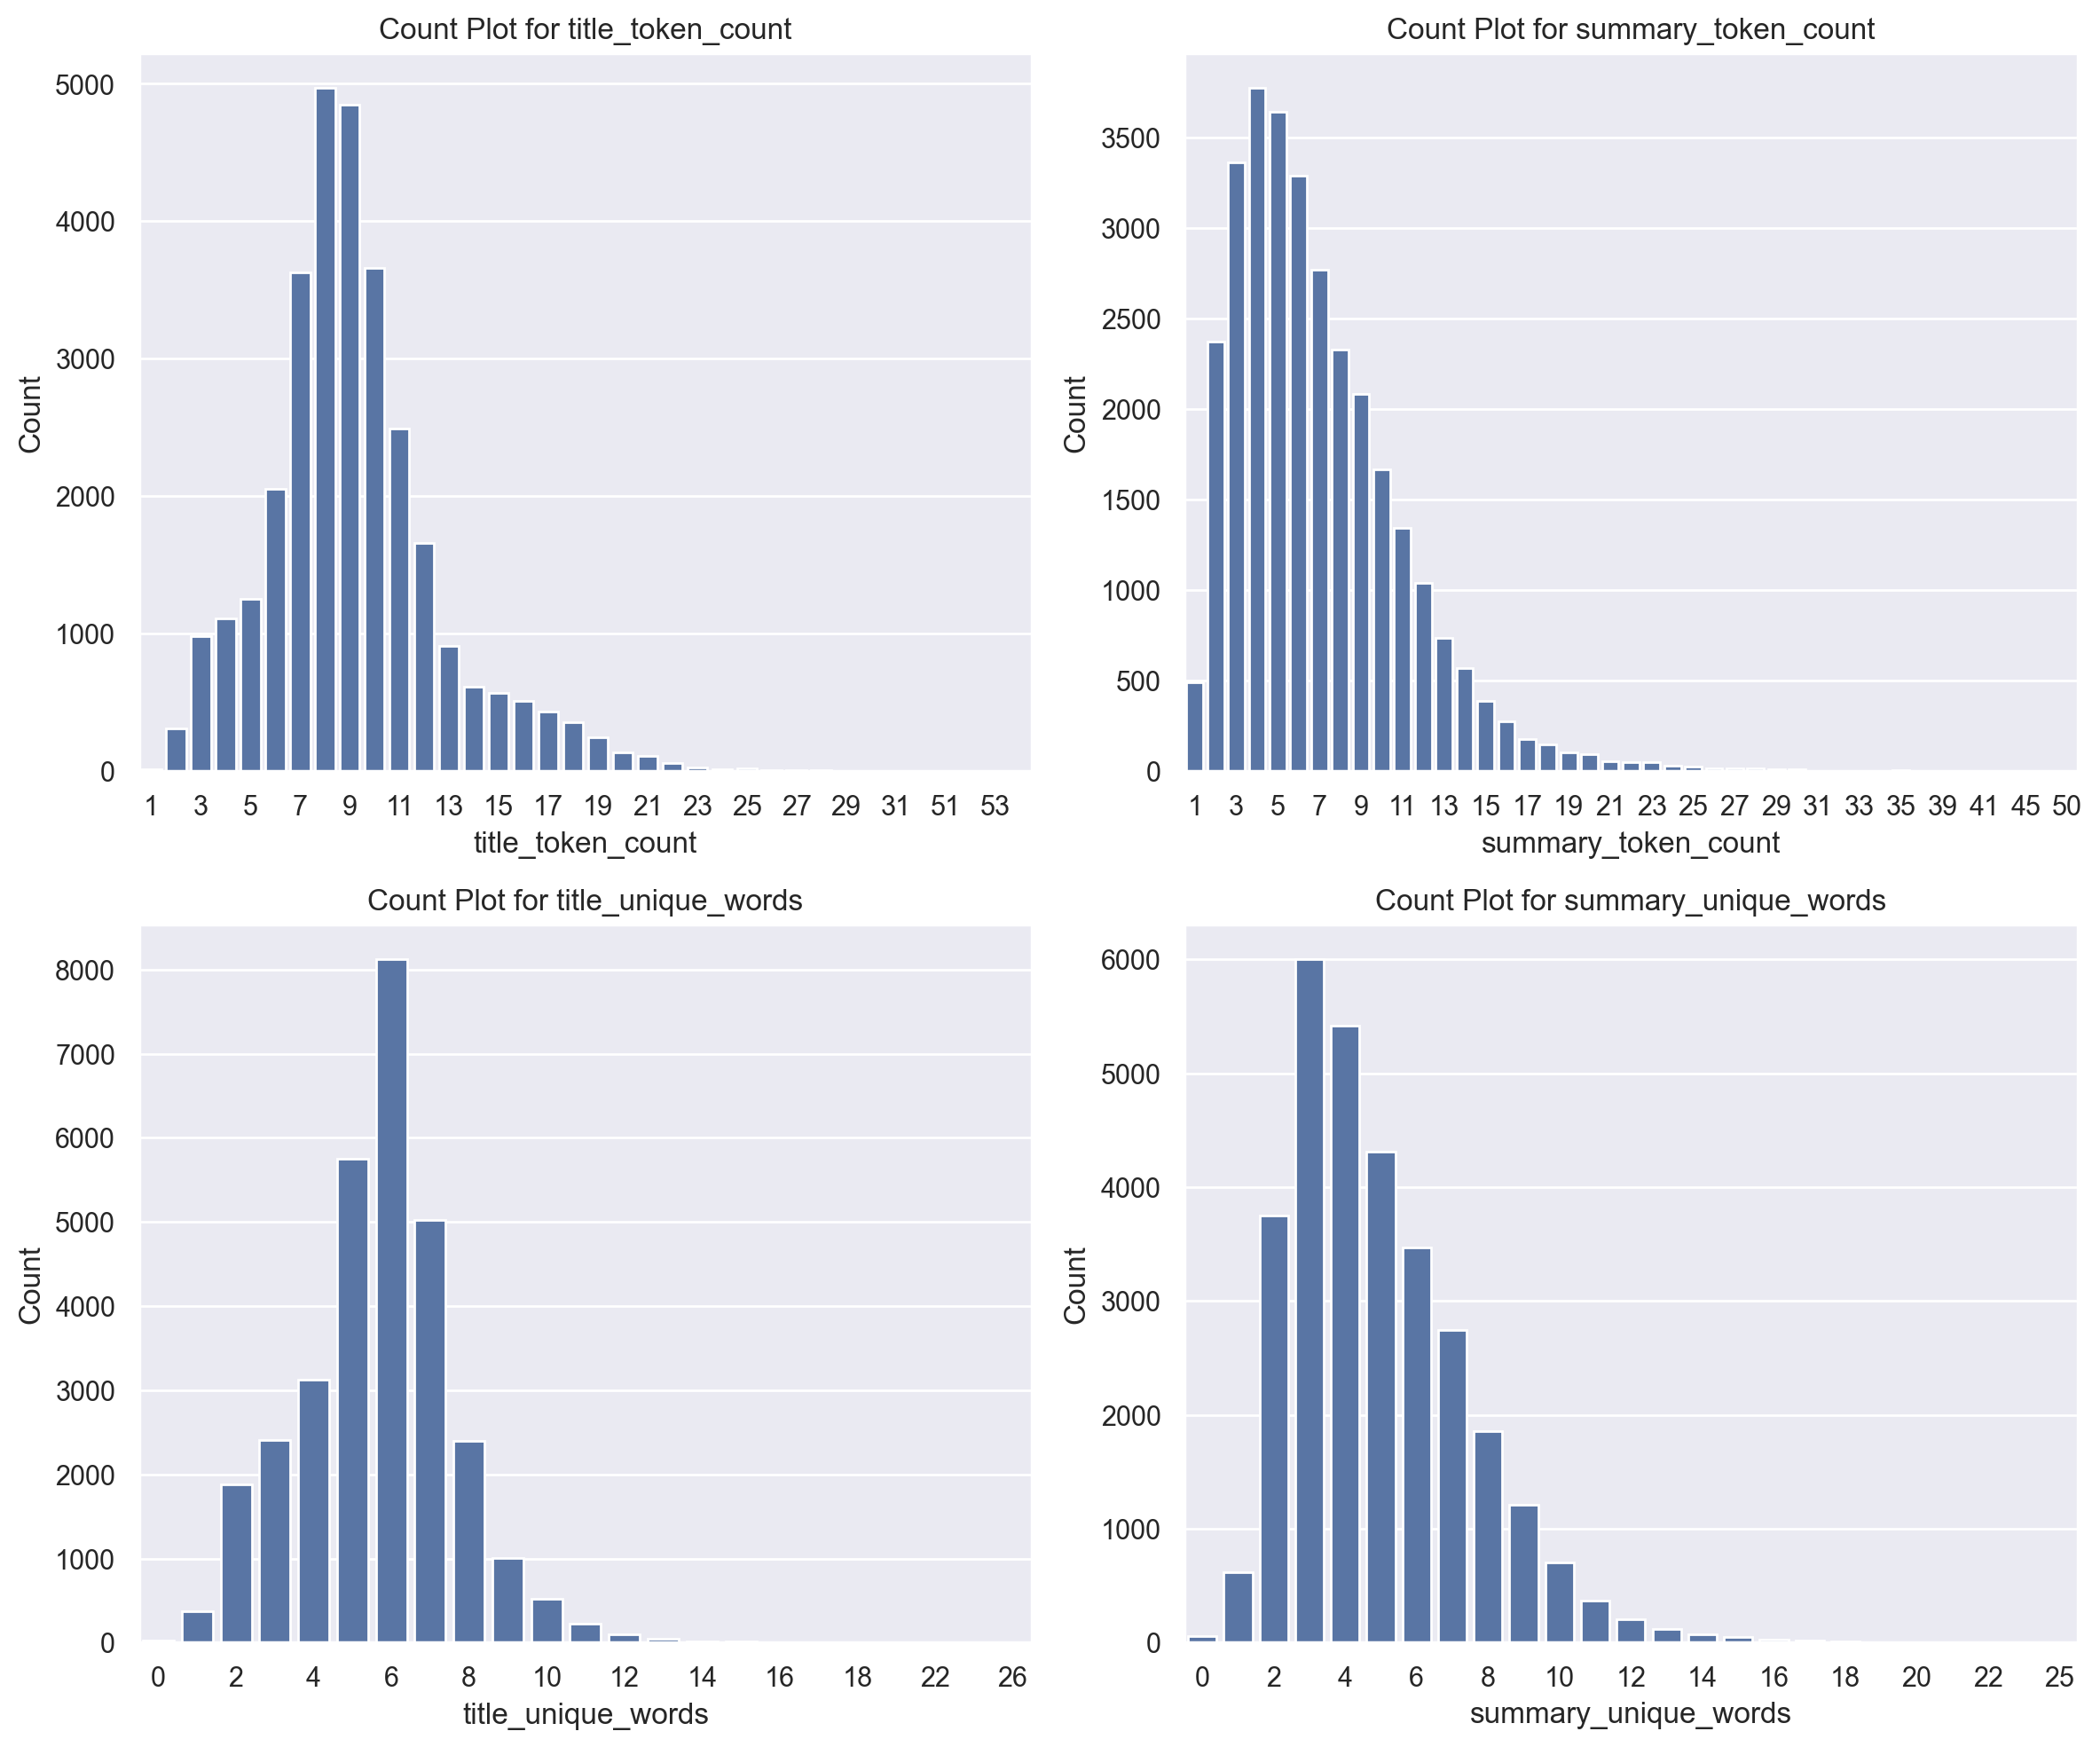

In [24]:
variables = ['title_token_count', 'summary_token_count', 'title_unique_words', 'summary_unique_words']

# Set up 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through each variable and plot
for i, var in enumerate(variables):
    sns.countplot(data=cap_nyt, x=var, ax=axes[i])
    axes[i].set_title(f'Count Plot for {var}', fontsize=12)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')

#reduce the number of ticks for X axis
for ax in axes:
    labels = ax.get_xticklabels()
    for i, label in enumerate(labels):
        if i % 2 != 0:  # show every other label
            label.set_visible(False)
            
# Adjust layout
plt.tight_layout()
plt.show()

Title token counts are more normally distributed, while summary token counts are more heavily skewed to the right. Note that the summaries have been created by Comparative Agendas Project. Perhaps, they have been trying to make them more consise. At the same time, summaries may be more useful for our analysis as they are more informative, while titles may be vague or metaphorical. For example, the title below does not really tell us about the subject of the article, while the summary clearly does:

In [25]:
row = cap_nyt[cap_nyt['article_id'] == 26406].iloc[0]
print(f"Title: {row['title']}")
print("")
print(f"Summary: {row['summary']}")

Title: Bold Goal, Risky Path The New York Times February 3, 2005 Thursday  Correction Appended  Late Edition - Final SECTION: Section A; Column 5; National Desk; STATE OF THE UNION: NEWS ANALYSIS; Pg. 1 LENGTH: 1210 words HEADLINE: Bold Goal, Risky Path BY

Summary: Bush switches goals from foreign policy to domestic in second term with social security reform


Note that the title is messy, we should shrink it to "Bold Goal, Risky Path", as well as other titles if there are any.

In [26]:
cap_nyt[cap_nyt['title'].str.contains("The New York Times", case=False, na=False)].shape[0]

4

In [27]:
#I won't bother here since there are only a few entries but this will be done in preprocessing before lemmatizing:
#cap_nyt['title_clean'] = cap_nyt['title'].str.replace(r'The New York Times.*', '', case=False, regex=True)

**Measure hapax legomena (unique words) in each row:**

In [28]:
def compute_hapax_counts(df, col):
    tokens = df[col].dropna().str.split().sum()
    global_counts = Counter(tokens)

    def row_hapax(text):
        if not isinstance(text, str):
            return 0
        return sum(1 for token in text.split() if global_counts[token] == 1)

    return df[col].apply(row_hapax)

# Apply to 'summary_clean' column
cap_nyt['title_hapax_count'] = compute_hapax_counts(cap_nyt, 'title_clean')
cap_nyt['summary_hapax_count'] = compute_hapax_counts(cap_nyt, 'summary_clean')

**Check the distributions of the hapax legomena counts using count plots:**

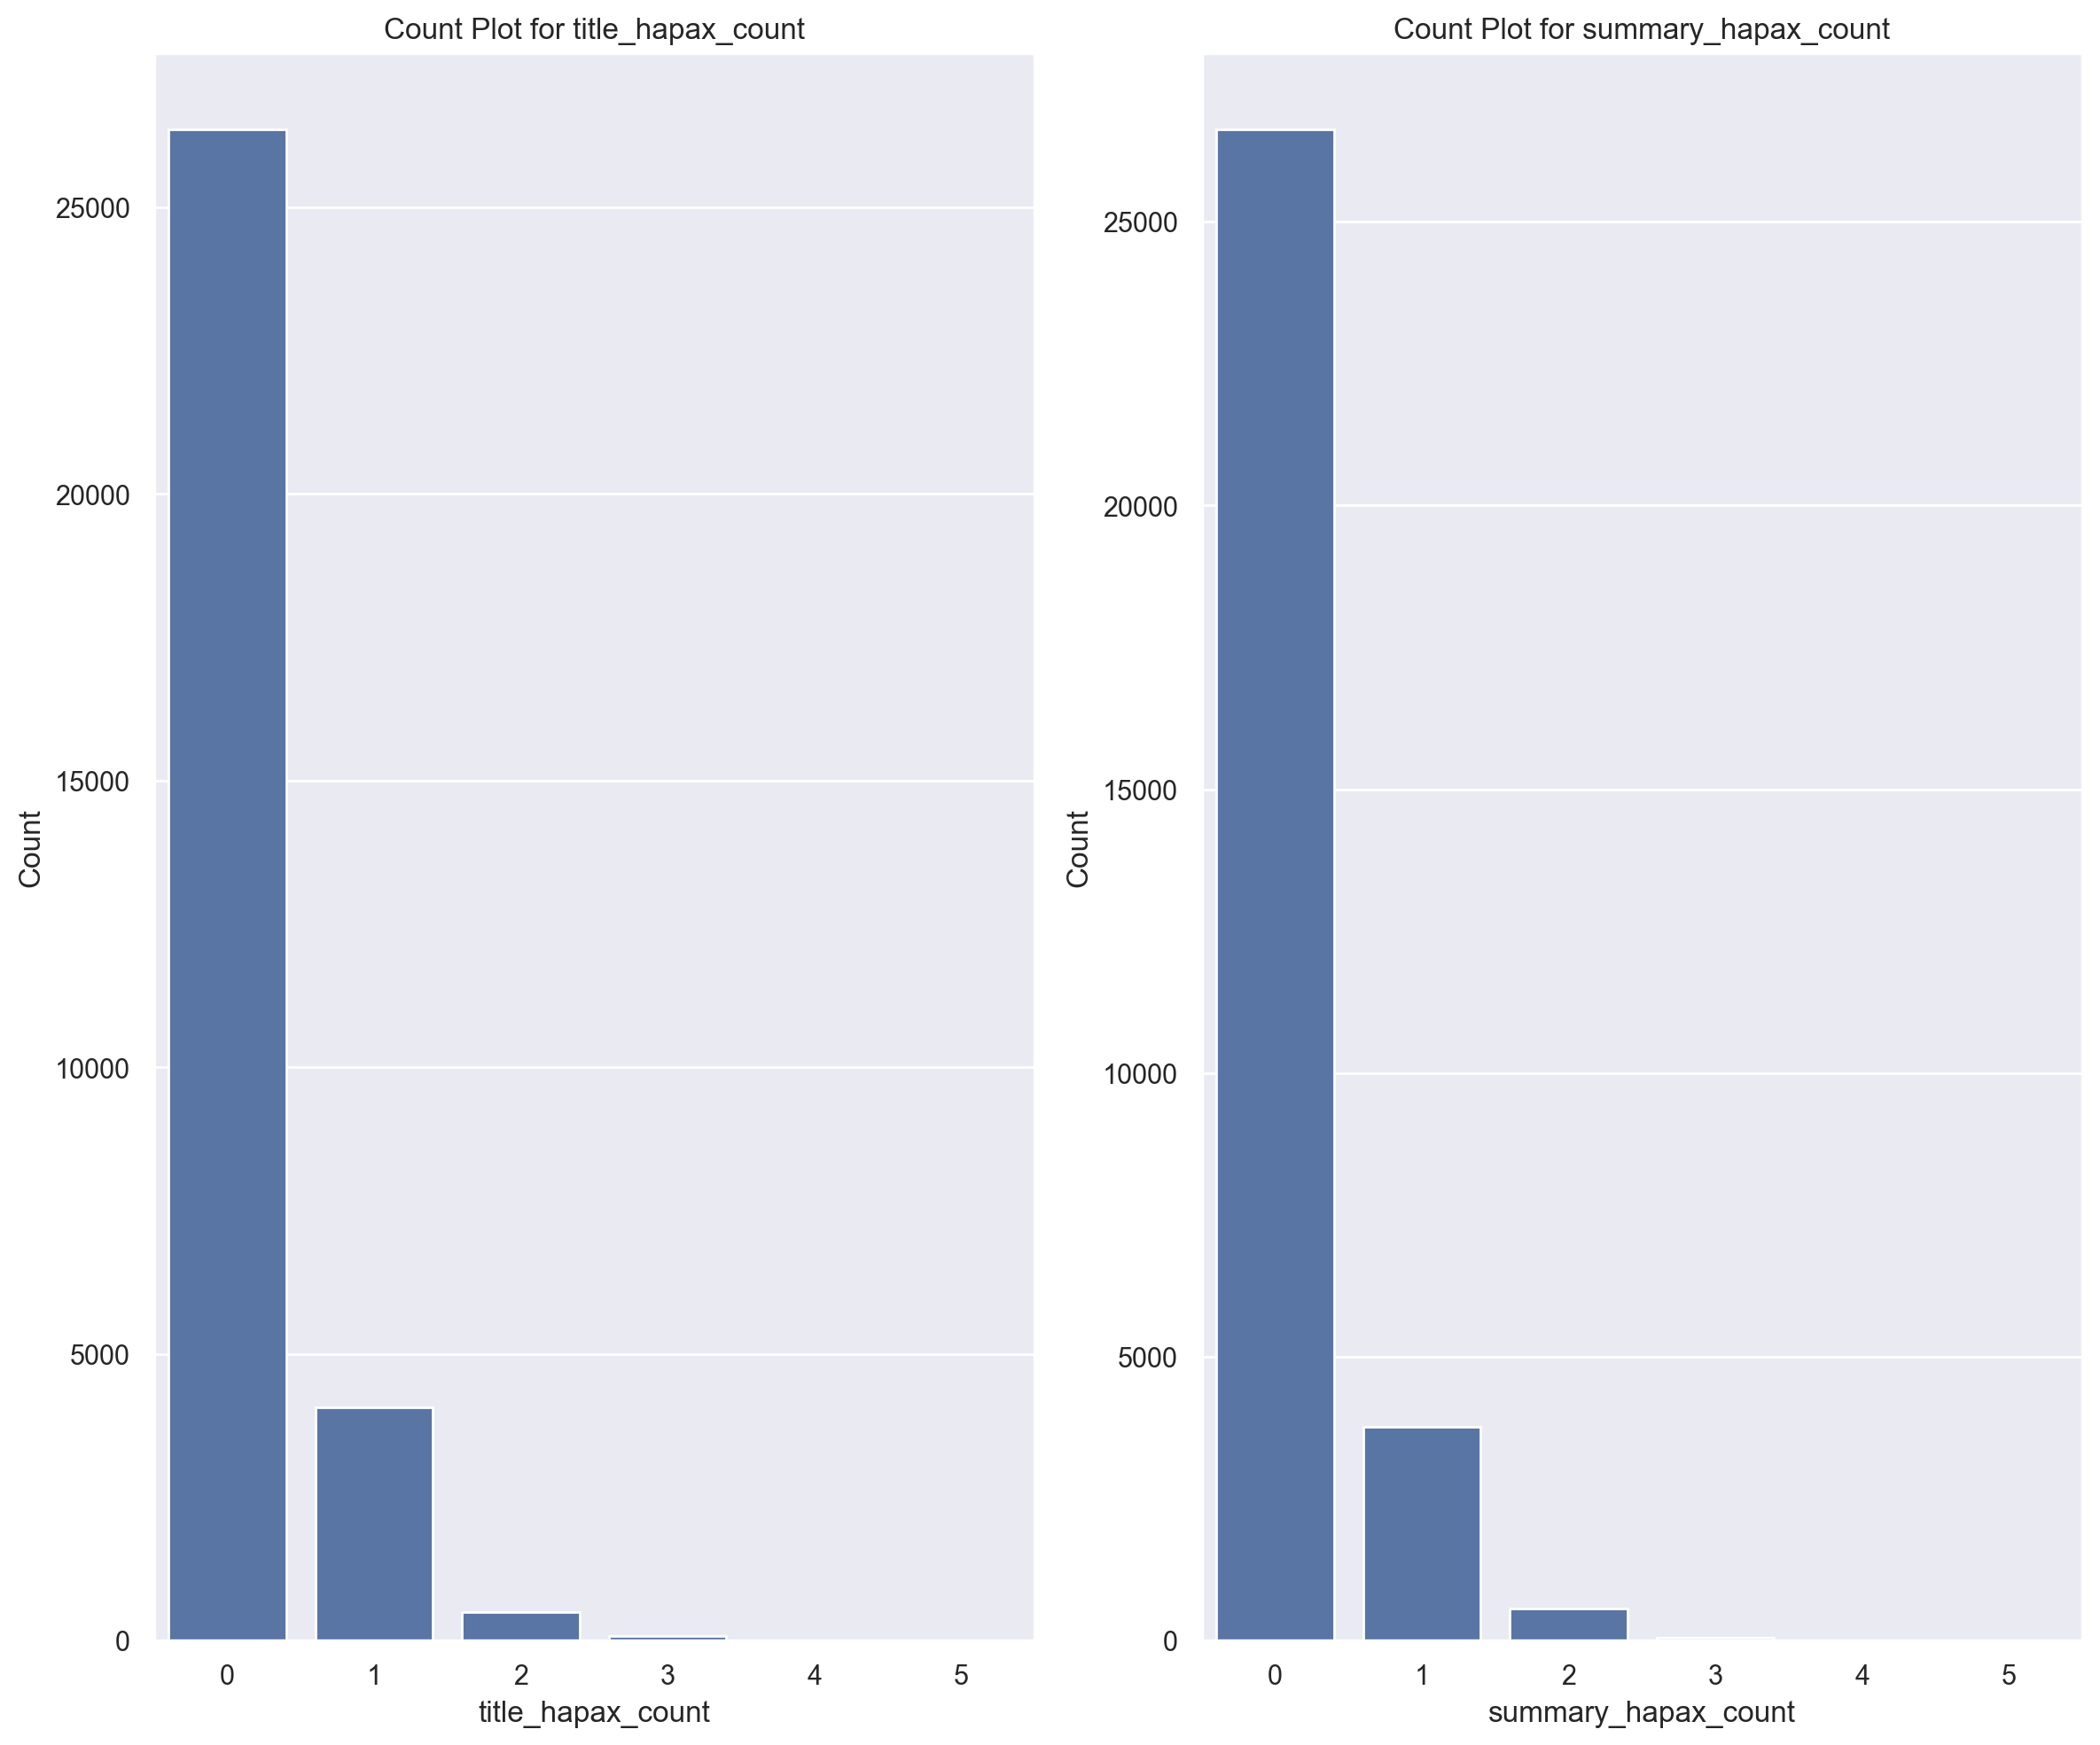

In [29]:
variables = ['title_hapax_count', 'summary_hapax_count']

# Set up 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 10))

# Loop through each variable and plot
for i, var in enumerate(variables):
    sns.countplot(data=cap_nyt, x=var, ax=axes[i])
    axes[i].set_title(f'Count Plot for {var}', fontsize=12)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
            
# Adjust layout
plt.tight_layout()
plt.show()

Titles and summary have really similar unique word counts among the articles, with titles having slightly more.